In [3]:
import sklearn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Classifying Digits with ANN

In [2]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [4]:
# returned as panda dataframes by fetch_openml
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [5]:
# convert pd frame to numpy
X = X.values
y = y.astype(int).values

In [6]:
# normalize pixel values within [-1, 1] -> (gradient more stable)
X = ((X/255) - 0.5) * 2

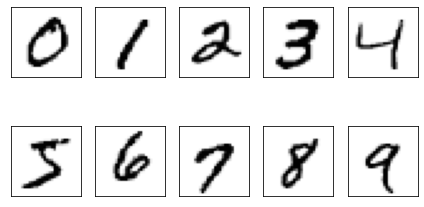

In [7]:
# plot some digits
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten() # 1D iterator over array
for i in range(10):
    img = X[y==i][0].reshape(28,28)
    ax[i].imshow(img, cmap="Greys")
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

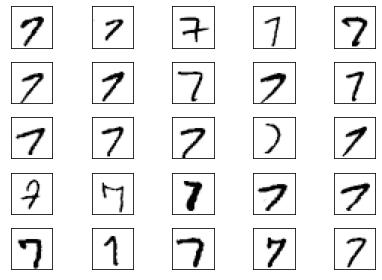

In [8]:
# plot the different variants of 7
digit = 7

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    img = X[y==digit][i].reshape(28,28)
    ax[i].imshow(img, cmap="Greys")
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

# test set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                  test_size=10000, 
                                                  random_state=123,
                                                  stratify=y) # stratify to make samples representative

# train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp,
                                                  test_size=5000,
                                                  random_state=123,
                                                  stratify=y_temp)

### Implementing a MLP

<img src="mlp.png" alt="mlp" width="500"/>

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def int_to_onehot(y, num_labels):
    """
    Convert digit label into a one hot label (horizontal vector)
    """
    onehots = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        onehots[i, val] = 1
    return onehots

In [11]:
class MLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        self.num_classes = num_classes
        # hidden layer
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(loc=0.0, scale=0.1, 
                                  size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1,
                                     size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # inner
        z_h = x @ self.weight_h.T + self.bias_h
        a_h = sigmoid(z_h)
        # outer
        z_out = a_h @ self.weight_out.T + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        """ 
        Loss function is MSE: 1/n * (prediction - actual)**2
        ---
        Calculate gradients for backpropogation and weight updates
        1. d_loss/d_w_out & d_loss/d_b_out
        2. d_loss/d_w_h   & d_loss/d_b_h
        """
        y_onehot = int_to_onehot(y, self.num_classes)
        
        # 1. Outer weights 
        # d_loss/d_w_out = d_loss/d_a_out * d_a_out/d_z_out * d_z_h/d_w_out
        # d_loss/d_b_out = d_loss/d_a_out * d_a_out/d_z_out * d_z_h/d_b_out
        # d_loss / d_a_out
        g_o1 = -2 * (y_onehot - a_out) / y.shape[0]
        # d_a_out / d_z_out ; derivative of sigmoid = sigmoid * (1 - sigmoid)
        g_o2 = a_out * (1 - a_out)
        # d_z_out/d_w_out
        g_o3 = a_h
        # d_z_out/d_b_out = 1
        g_o4 = np.ones(a_h.shape[0])

        d_loss__d_w_out = (g_o1 * g_o2).T @ g_o3
        d_loss__d_b_out = (g_o1 * g_o2).T @ g_o4

        # 2. Inner weights
        # g = d_loss/d_a_out * d_a_out/d_z_out
        g = g_o1 * g_o2
        # d_loss/d_w_h = g * d_z_out/d_a_h * d_a_h/d_z_h * d_z_h/d_w_h
        # d_loss/d_b_h = g * d_z_out/d_a_h * d_a_h/d_z_h * d_z_h/d_b_h
        # d_z_out/d_a_h
        g_i1 = self.weight_out
        # d_a_h/d_z_h
        g_i2 = a_h * (1 - a_h)
        # d_z_h/d_w_h
        g_i3 = x
        # d_z_h/d_b_h
        g_i4 = np.ones(x.shape[0])

        d_loss__d_w_h = ((g @ g_i1) * g_i2).T @ g_i3
        d_loss__w_b_h = ((g @ g_i1) * g_i2).T @ g_i4

        return (d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__w_b_h)

### Training the network

In [12]:
from tqdm.notebook import tqdm
import time

In [13]:
num_epochs = 50
minibatch_size = 100

def minibatch_gen(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    perm_idx = np.random.permutation(indices)
    X_perm = X[perm_idx]
    y_perm = y[perm_idx]
    for start_idx in range(0, indices.shape[0] - minibatch_size, minibatch_size):
        yield (X_perm[start_idx:start_idx+minibatch_size], 
               y_perm[start_idx:start_idx+minibatch_size])

In [14]:
def mse_loss(targets, probas, num_labels=10):
    onehots = int_to_onehot(targets, num_labels)
    return np.mean((onehots - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [15]:
# validate that the minibatch generator works
for i in range(num_epochs):
    minibatch = minibatch_gen(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch:
        break
    time.sleep(0.01)
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [16]:
# validate that the first pass works as expected
model = MLP(num_features=28*28, num_hidden=50, num_classes=10)
_, probas = model.forward(X_train_mini)
mse = mse_loss(y_train_mini, probas)
print(f"Inital MSE = {mse:.4f}")
preds = np.argmax(probas, axis=1)
acc = accuracy(y_train_mini, preds)
print(f"Initial Accuracy = {acc*100:.4f}%")

Inital MSE = 0.2746
Initial Accuracy = 4.0000%


In [17]:
def compute_mse_and_acc(model, X, y, minibatch_size=100):
    mse, correct_pred, num_examples = 0.0, 0, 0
    minibatch = minibatch_gen(X, y, minibatch_size)
    for i, (features, labels) in enumerate(minibatch):
        _, probs = model.forward(features)
        preds = np.argmax(probs, axis=1) # horiztonal one-hot vectors 
        mse += mse_loss(labels, probs)
        correct_pred += (preds == labels).sum()
        num_examples += labels.shape[0]
    
    mse /= i 
    acc = correct_pred / num_examples
    
    return mse, acc

In [18]:
def train(model, X_train, y_train, X_val, y_val, num_epochs, learning_rate=0.1, verbose=False):
    epoch_loss = []
    epoch_train_acc = []
    epoch_val_acc = []

    for i in range(num_epochs):
        minibatch = minibatch_gen(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch:
            # forward
            a_h, a_out = model.forward(X_train_mini)
            # update weights (backward)
            gradients = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            model.weight_out -= learning_rate * gradients[0]
            model.bias_out   -= learning_rate * gradients[1]
            model.weight_h   -= learning_rate * gradients[2]
            model.bias_h     -= learning_rate * gradients[3]

        # logging
        mse_train, acc_train = compute_mse_and_acc(model, X_train, y_train)
        _, acc_val = compute_mse_and_acc(model, X_val, y_val)
        epoch_loss.append(mse_train)
        epoch_train_acc.append(acc_train)
        epoch_val_acc.append(acc_val)
        
        if verbose:
            print(f"Epoch = {i}/{num_epochs} | "
                  f"Train MSE: {mse_train:.4f} | " 
                  f"Train Acc: {acc_train*100:.4f}% | " 
                  f"Val Acc: {acc_val*100:.4f}%")

    return epoch_loss, epoch_train_acc, epoch_val_acc

In [19]:
model = MLP(num_features=28*28, num_hidden=50, num_classes=10)
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_val_acc = train(model, X_train, y_train, X_val, y_val, num_epochs=50, verbose=True)

Epoch = 0/50 | Train MSE: 0.0501 | Train Acc: 76.0911% | Val Acc: 75.7959%
Epoch = 1/50 | Train MSE: 0.0312 | Train Acc: 85.3953% | Val Acc: 84.9388%
Epoch = 2/50 | Train MSE: 0.0243 | Train Acc: 87.9617% | Val Acc: 87.6939%
Epoch = 3/50 | Train MSE: 0.0209 | Train Acc: 89.3607% | Val Acc: 89.2041%
Epoch = 4/50 | Train MSE: 0.0188 | Train Acc: 90.2550% | Val Acc: 90.1224%
Epoch = 5/50 | Train MSE: 0.0174 | Train Acc: 90.6612% | Val Acc: 90.6122%
Epoch = 6/50 | Train MSE: 0.0164 | Train Acc: 91.1457% | Val Acc: 90.9184%
Epoch = 7/50 | Train MSE: 0.0155 | Train Acc: 91.4062% | Val Acc: 91.2449%
Epoch = 8/50 | Train MSE: 0.0148 | Train Acc: 91.8015% | Val Acc: 91.4694%
Epoch = 9/50 | Train MSE: 0.0143 | Train Acc: 91.9654% | Val Acc: 91.7143%
Epoch = 10/50 | Train MSE: 0.0138 | Train Acc: 92.3078% | Val Acc: 92.0408%
Epoch = 11/50 | Train MSE: 0.0134 | Train Acc: 92.4390% | Val Acc: 92.2449%
Epoch = 12/50 | Train MSE: 0.0131 | Train Acc: 92.6211% | Val Acc: 92.2857%
Epoch = 13/50 | Train 

### Evaluating the Neural Network

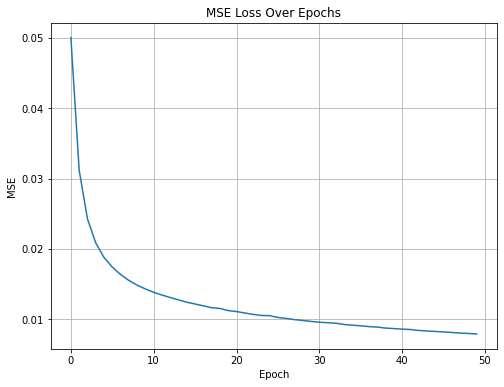

In [23]:
plt.figure(figsize=(8,6))
idx = [i for i in range(num_epochs)]
plt.plot(idx, epoch_loss)
plt.title("MSE Loss Over Epochs")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.grid()
plt.show()

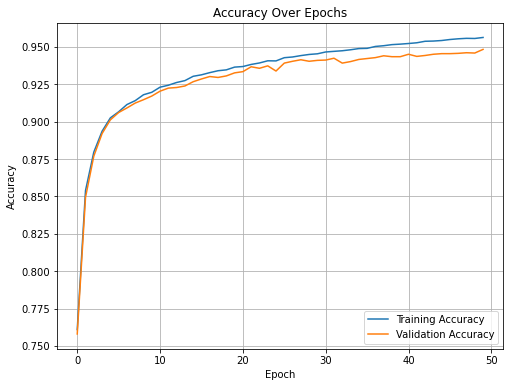

In [27]:
plt.figure(figsize=(8,6))
idx = [i for i in range(num_epochs)]
plt.plot(idx, epoch_train_acc, label="Training Accuracy")
plt.plot(idx, epoch_val_acc, label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.legend(loc="lower right")
plt.show()

As we know already, when training accuracy is higher than validation, the model is overfitting. 

In [29]:
# test set evaluation 
_, probs_test = model.forward(X_test)
preds = np.argmax(probs_test, axis=1)
acc = accuracy(y_test, preds)
print(f"Test Accuracy = {acc*100:.4f}%")

Test Accuracy = 94.5600%
